In [1]:
wdir='./' ## working dir
fName='nb24_'
gColab=True  ## set this to False if running locally
if(gColab):
    ## Mount google drive to the machine running this nb
    from google.colab import drive
    drive.mount('/content/drive')
    ## must also specify the absolute path to the working dir
    wdir='/content/drive/MyDrive/ysNN/partB/'

Mounted at /content/drive


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
##from matplotlib.colors import DivergingNorm
from matplotlib.colors import TwoSlopeNorm
import tensorflow as tf
import random

gseed=99
if(1):
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = ""
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    tf.random.set_seed(gseed)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

## set off randomness
np.random.seed(gseed)
random.seed(gseed)
os.environ['PYTHONHASHSEED']=str(gseed)
tf.random.set_seed(gseed)


In [3]:
#####-------------  Fit and Test data -----------------------------
degree=4
nMonoms=int((int(degree/2+1))**2)
maxShear=9.0e+16  ###  NN-model without convexity constraints  (DO NOT exclude data)
vPoints,vFitKG=[],[]
ff=open(wdir+'aCVXbdry_deg_4.txt','r')
for line in ff:
    line=line.strip()
    if(line):
        line=line.split(',')
        #################
        line=[float(x) for x in line]
        if(abs(line[nMonoms-1])<maxShear):
            vPoints.append(line[0:nMonoms])
            vFitKG.append(line[-1])
        #vPoints.append([float(x) for x in line[0:nMonoms]])
        #vFitKG.append(float(line[-1]))
ff.close()
vPoints=np.array(vPoints)
vFitKG=np.array(vFitKG)
nPoints=vPoints.shape[0]
print(vPoints.shape,nPoints)
## investigate spread
cntp=np.sum(vPoints,axis=0)/nPoints
for kk in range(cntp.shape[0]):
    print('center point[{kk}] = ',cntp[kk])
print('center point = ',cntp)
## compare to Mises
vMises=np.array([1, -2, 3, -2, 1, 6, -6, 6, 9],dtype=np.double)
print('von Mises = ',vMises)
dxMax=np.zeros(nMonoms)
for kk in range(nMonoms):
    dxMax[kk]=np.max(np.abs(vPoints[:,kk]-cntp[kk]))
    print(kk,': dxMax = ',dxMax[kk])
### spread is large --->>> normalize the data
### also, exclude the first component: this is '1' for all
vPoints=vPoints[:,1:]
dxMax=dxMax[1:]
cntp=cntp[1:]
nMonoms-=1
for kk in range(nMonoms):
    vPoints[:,kk]=(vPoints[:,kk]-cntp[kk])/dxMax[kk]
print(vPoints[0,:])
print(vPoints.shape)

## Targets
vTargets=np.ones((nPoints,1))
print('number of data points = ',vTargets.shape[0])
####-------------------------------------------------Test data---------
vTestPoints,vTestKG=[],[]
ff=open(wdir+'aCVXbdry_deg_4_test.txt','r')
for line in ff:
    line=line.strip()
    if(line):
        line=line.split(',')
        ###############
        line=[float(x) for x in line]
        #if(max([abs(x) for x in line[0:nMonoms]])<maxShear and(abs(line[-1])<10.0)):
        if(abs(line[nMonoms])<maxShear):
            vTestPoints.append(line[1:nMonoms+1])
            vTestKG.append(line[-1])
        #vTestPoints.append([float(x) for x in line[1:nMonoms+1]])
        #vTestKG.append(float(line[-1]))
ff.close()
vTestPoints=np.array(vTestPoints)
vTestKG=np.array(vTestKG)
nTestPoints=vTestPoints.shape[0]
print(vTestPoints[0,:])
print('Total number of data points: ',vTestPoints.shape,nTestPoints)
for kk in range(nMonoms):
    vTestPoints[:,kk]=(vTestPoints[:,kk]-cntp[kk])/dxMax[kk]
print(vTestPoints[0,:])


(20000, 9) 20000
center point[{kk}] =  1.0
center point[{kk}] =  -1.6129362192236751
center point[{kk}] =  3.454157357252988
center point[{kk}] =  -1.7653572545874991
center point[{kk}] =  1.862396791843772
center point[{kk}] =  6.111839159843277
center point[{kk}] =  -5.921176129510384
center point[{kk}] =  6.1850318108821885
center point[{kk}] =  9.12879232596765
center point =  [ 1.         -1.61293622  3.45415736 -1.76535725  1.86239679  6.11183916
 -5.92117613  6.18503181  9.12879233]
von Mises =  [ 1. -2.  3. -2.  1.  6. -6.  6.  9.]
0 : dxMax =  0.0
1 : dxMax =  8.420482078405513
2 : dxMax =  60.72447809357019
3 : dxMax =  100.28299963683395
4 : dxMax =  123.27000099311208
5 : dxMax =  78.44972776373547
6 : dxMax =  72.87225156911263
7 : dxMax =  125.62917310072585
8 : dxMax =  246.0112253395461
[-0.16263977  0.22631836  0.0171534   0.06745236 -0.01502758 -0.00761905
  0.04001134  0.0226377 ]
(20000, 8)
number of data points =  20000
[-2.52396881 10.57185162 -0.95742041  5.89453

In [4]:
####---------------------------Validation data---------
vValidPoints,vValidKG=[],[]
ff=open(wdir+'aCVXbdry_deg_4_Valid.txt','r')
for line in ff:
    line=line.strip()
    if(line):
        line=line.split(',')
        ################
        line=[float(x) for x in line]
        if(abs(line[nMonoms])<maxShear):
            vValidPoints.append(line[1:nMonoms+1])
            vValidKG.append(line[-1])
ff.close()
vValidPoints=np.array(vValidPoints)
vValidKG=np.array(vValidKG)
nValidPoints=vValidPoints.shape[0]
for kk in range(nMonoms):
    vValidPoints[:,kk]=(vValidPoints[:,kk]-cntp[kk])/dxMax[kk]
#---------
vValidTestPoints,vValidTestKG=[],[]
ff=open(wdir+'aCVXbdry_deg_4_Valid_test.txt','r')
for line in ff:
    line=line.strip()
    if(line):
        line=line.split(',')
        ################# Exclude points with too small pure shear
        line=[float(x) for x in line]
        if(abs(line[nMonoms])<maxShear):
            vValidTestPoints.append(line[1:nMonoms+1])
            vValidTestKG.append(line[-1])
ff.close()
vValidTestPoints=np.array(vValidTestPoints)
vValidTestKG=np.array(vValidTestKG)
nValidTestPoints=vValidTestPoints.shape[0]
print(vValidTestPoints[0,:])
print('Total number of validation points: ',vValidTestPoints.shape,nValidTestPoints)
for kk in range(nMonoms):
    vValidTestPoints[:,kk]=(vValidTestPoints[:,kk]-cntp[kk])/dxMax[kk]
print(vValidTestPoints[0,:])

[-7.19721606  4.76161788  4.85980804 -0.62897878  2.39015383 -8.10594685
  5.72878595  7.37656203]
Total number of validation points:  (133927, 8) 133927
[-0.66317816  0.02153103  0.06606469 -0.02021072 -0.04744039 -0.02998083
 -0.00363169 -0.00712256]


In [5]:
########## MODEL----------------------
def pAct(x):
    return 0.5*((1+tf.math.sign(x))*(x+0.01)+0.01*(1-tf.math.sign(x))*tf.math.exp(100.0*tf.math.minimum(0.0,x)))

nun1=200
model=tf.keras.Sequential(
        [
          tf.keras.layers.Dense(nun1,activation=pAct, input_shape=(8,)),
          tf.keras.layers.Dense(nun1,activation=pAct),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ]
    )
model.load_weights(wdir+'aFitCVXdeg4_12_C_9D4_Weights', skip_mismatch=False, by_name=False, options=None)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               1800      
                                                                 
 dense_1 (Dense)             (None, 200)               40200     
                                                                 
 dense_2 (Dense)             (None, 1)                 201       
                                                                 
Total params: 42,201
Trainable params: 42,201
Non-trainable params: 0
_________________________________________________________________


In [6]:
pTest=(np.array([ -2, 3, -2, 1, 6, -6, 6, 9])-cntp)/dxMax
print('model(Mises) = ',tf.get_static_value(model(pTest.reshape((1,8))))[0,0])
print('model(Center) = ',tf.get_static_value(model((cntp-cntp).reshape((1,8))))[0,0])
pTest=(np.array([ -0.6984, 1.4969, -2.3838, 1.4568, 4.8808, -1.0150, 8.7095, 23.4498])-cntp)/dxMax  ###AA2090-T3 solution_Customized
print('model(AA2090T3_old_solution_paper) = ',tf.get_static_value(model(pTest.reshape((1,8))))[0,0])
pTest=(np.array([-0.3454, -0.4093, -1.6025,  1.4162,  3.0605,  0.5849, 11.0931, 22.0 ])-cntp)/dxMax  ###AA2090-T3 solution_Unconstrained
print('model(AA2090T3_global_optimizer) = ',tf.get_static_value(model(pTest.reshape((1,8))))[0,0])
pTest=(np.array([-0.4704,  0.8722, -1.8607,  1.5515,  4.8526, -3.8269, 10.6607, 19.7888 ])-cntp)/dxMax  ###AA2090-T3 solution_3
print('model(AA2090T3_sol_thresh_0p5) = ',tf.get_static_value(model(pTest.reshape((1,8))))[0,0])
pTest=(np.array([-0.4790,  0.8828, -1.8668,  1.5487,  4.7703, -3.6969, 10.6162,  19.8541 ])-cntp)/dxMax  ###AA2090-T3 solution_4
print('model(AA2090T3_sol_thresh_0p45) = ',tf.get_static_value(model(pTest.reshape((1,8))))[0,0])
pTest=(np.array([-0.3445,  0.7077, -1.6118,  1.45,  4.0888, -3.3357, 11.2301, 21.5589 ])-cntp)/dxMax  ###AA2090-T3 solution_5
print('model(AA2090T3_sol_thresh_0p4) = ',tf.get_static_value(model(pTest.reshape((1,8))))[0,0])

vData=[
{'id':'10','material':'Brass','param':[1.0, -1.8644, 2.9499, -2.1475, 1.1347, 6.375, -6.1573, 6.9275, 10.3633]},
{'id':'11','material':'Copper','param':[1.0, -1.7363, 2.5304, -1.9759, 1.2236, 6.3702, -6.5197, 7.057, 11.4808]},
{'id':'12','material':'Aluminum','param':[1.0, -1.3422, 2.4433, -1.8689, 0.9905, 6.0261, -1.6115, 6.5337, 6.5264]},
{'id':'13','material':'A5052-O','param':[1.0, -1.6744, 1.9748, -1.4843, 1.0, 5.8452, -2.0841, 5.6551, 6.4509]},
{'id':'14','material':'A5182-O','param':[1.0, -1.6608, 2.287, -1.9816, 1.0281, 5.7451, -4.7334, 6.122, 8.643]},
{'id':'15','material':'A6016-T4','param':[1.0, -1.7273, 2.3675, -1.9619, 1.2945, 6.3148, 0.0996, 7.1386, 5.0025]},
{'id':'15B','material':'AA6016-T4','param':[1.0, -1.7273, 2.3675, -1.9619, 1.2945, 6.3016, 0.0289, 7.0354, 5.1532]},
{'id':'16','material':'AISI 430','param':[1.0, -1.7401, 2.699, -2.1818, 1.0, 5.7401, -5.8931, 6.1818, 9.1941]},
{'id':'17','material':'AISI 409','param':[1.0, -2.2143, 3.0112, -2.2456, 1.0, 6.2143, -6.7541, 6.2456, 9.7428]},
{'id':'18','material':'DD Steel','param':[1.0, -2.2456, 3.6695, -2.6918, 1.0347, 5.9369, -6.1607, 6.4525, 7.9083]},
{'id':'19','material':'AISI 304','param':[1.0, -1.9167, 3.197, -2.3152, 1.2518, 6.4377, -6.9885, 7.3398, 11.0854]},
{'id':'20','material':'IF Steel','param':[1.0, -2.7179, 4.177, -3.0688, 1.0327, 6.8832, -9.6978, 7.2993, 11.8839]},
{'id':'21','material':'440W HSS','param':[1.0, -1.6331, 2.5308, -2.034, 1.0495, 5.5837, -5.5725, 6.0835, 8.9923]},
{'id':'1','material':'A2008-T4','param':[1.0, -1.8579,2.9549,-2.0742,1.4946,6.56,-4.1447,7.949,8.1031]},
{'id':'2','material':'Steel(NUM93)','param':[1.0, -2.5663,3.6988,-2.4392,0.8784,5.7851,-7.6630,5.8435,8.2863]}
]
for dd in vData:
    pTest=(np.array(dd['param'][1:])-cntp)/dxMax
    mOFp=tf.get_static_value(model(pTest.reshape((1,8))))[0,0]
    print(dd['id']+', '+dd['material']+':  m(p) = ',mOFp,';  g(p)=m(p)-0.5 = ',mOFp-0.5)

model(Mises) =  1.5560561e-14
model(Center) =  1.6471316e-14
model(AA2090T3_old_solution_paper) =  0.083558515
model(AA2090T3_global_optimizer) =  1.0
model(AA2090T3_sol_thresh_0p5) =  0.49871218
model(AA2090T3_sol_thresh_0p45) =  0.45174858
model(AA2090T3_sol_thresh_0p4) =  0.39875215
10, Brass:  m(p) =  2.542122e-14 ;  g(p)=m(p)-0.5 =  -0.4999999999999746
11, Copper:  m(p) =  3.6908725e-14 ;  g(p)=m(p)-0.5 =  -0.4999999999999631
12, Aluminum:  m(p) =  6.9044476e-10 ;  g(p)=m(p)-0.5 =  -0.49999999930955524
13, A5052-O:  m(p) =  2.2130335e-09 ;  g(p)=m(p)-0.5 =  -0.49999999778696647
14, A5182-O:  m(p) =  8.139113e-12 ;  g(p)=m(p)-0.5 =  -0.4999999999918609
15, A6016-T4:  m(p) =  0.00074856816 ;  g(p)=m(p)-0.5 =  -0.49925143184373155
15B, AA6016-T4:  m(p) =  0.00020548402 ;  g(p)=m(p)-0.5 =  -0.4997945159848314
16, AISI 430:  m(p) =  5.0600534e-13 ;  g(p)=m(p)-0.5 =  -0.499999999999494
17, AISI 409:  m(p) =  5.9923437e-13 ;  g(p)=m(p)-0.5 =  -0.49999999999940076
18, DD Steel:  m(p) =  3

In [7]:
#idxBdry=np.argwhere(vTestKG>=0.0)
#vFitBdryModel=model(vTestPoints[idxBdry[:,0]]).numpy()
vFitBdryModel=model(vPoints).numpy()
#idxBdry=np.argwhere(vValidTestKG>=0.0)
#vValidBdryModel=model(vValidTestPoints[idxBdry[:,0]]).numpy()
vValidBdryModel=model(vValidPoints).numpy()

vTestModel=model(vTestPoints).numpy()
vValidModel=model(vValidTestPoints).numpy()

vsgn=np.sign(0.5-vTestModel)[:,0].astype(int)-np.sign(vTestKG).astype(int)
idxTrue=np.argwhere(vsgn==0)
print(idxTrue.shape[0],vTestPoints.shape[0],idxTrue.shape[0]/vTestPoints.shape[0])

232171 267647 0.8674522785609403


In [8]:
def errTable(treshh,vModel,vLabel,nDataCvx,nDataNCvx,prt=True):
    ####-------predicted convex
    idxPredConvex=np.argwhere(vModel[:,0]<=treshh)
    nTotalPredConvex=idxPredConvex.shape[0]
    nPredTrueConvex=np.sum((vLabel[idxPredConvex[:,0]]>=0.0).astype(int))
    nPredFalseConvex=np.sum(nTotalPredConvex -nPredTrueConvex)
    ####--------predicted Non-Convex
    idxPredNonConvex=np.argwhere(vModel[:,0]>treshh)
    nTotalPredNonConvex=idxPredNonConvex.shape[0]
    nPredTrueNonConvex=np.sum((vLabel[idxPredNonConvex[:,0]]<0.0).astype(int))
    nPredFalseNonConvex=np.sum(nTotalPredNonConvex -nPredTrueNonConvex)
    if(prt):
        print('------------------------Threshold = ',treshh)
        print('Total number points predicted convex: ',nTotalPredConvex)
        print(f'Total number of predicted true convex: {nPredTrueConvex} ({nPredTrueConvex/nDataCvx}%) ')
        print(f'Total number of predicted false convex: {nPredFalseConvex} ({nPredFalseConvex/nDataNCvx}%)')
        print('Total number points predicted NonConvex: ',nTotalPredNonConvex)
        print(f'Total number of predicted true NonConvex: {nPredTrueNonConvex} ({nPredTrueNonConvex/nDataNCvx}%)')
        print(f'Total number of predicted false NonConvex: {nPredFalseNonConvex} ({nPredFalseNonConvex/nDataCvx}%)')
        print('--------------------------------------------------------')
    return [nTotalPredConvex,nPredTrueConvex,nPredFalseConvex,
            nTotalPredNonConvex,nPredTrueNonConvex,nPredFalseNonConvex]

In [9]:
print('Error table of the TEST (fitting) data')
idxTrueConvex=np.argwhere(vTestKG>=0.0)
print('Total number of points true convex: ',idxTrueConvex.shape)
idxTrueNonConvex=np.argwhere(vTestKG<0.0)
print('Total number of points true NonConvex: ',idxTrueNonConvex.shape)
treshh=0.5
vPredicted=errTable(treshh,vTestModel,vTestKG,idxTrueConvex.shape[0],idxTrueNonConvex.shape[0])
treshh=0.4
vPredicted=errTable(treshh,vTestModel,vTestKG,idxTrueConvex.shape[0],idxTrueNonConvex.shape[0])

Error table of the TEST (fitting) data
Total number of points true convex:  (123940, 1)
Total number of points true NonConvex:  (143707, 1)
------------------------Threshold =  0.5
Total number points predicted convex:  151450
Total number of predicted true convex: 119957 (0.9678634823301597%) 
Total number of predicted false convex: 31493 (0.21914729275539813%)
Total number points predicted NonConvex:  116197
Total number of predicted true NonConvex: 112214 (0.7808527072446019%)
Total number of predicted false NonConvex: 3983 (0.03213651766984024%)
--------------------------------------------------------
------------------------Threshold =  0.4
Total number points predicted convex:  130575
Total number of predicted true convex: 111175 (0.8970066161045668%) 
Total number of predicted false convex: 19400 (0.13499690342154522%)
Total number points predicted NonConvex:  137072
Total number of predicted true NonConvex: 124307 (0.8650030965784548%)
Total number of predicted false NonConvex:

In [10]:
print('model acc on the fit dataset = ',(119957.0+112214.0)/267647.0)
print('model acc on the validation dataset = ',(58876.0+55711.0)/133927.0)

model acc on the fit dataset =  0.8674522785609403
model acc on the validation dataset =  0.8555929722908748


In [11]:
print('Error table of the Validation (test) data')
idxTrueConvex=np.argwhere(vValidTestKG>=0.0)
print('Total number of points true convex: ',idxTrueConvex.shape)
idxTrueNonConvex=np.argwhere(vValidTestKG<0.0)
print('Total number of points true NonConvex: ',idxTrueNonConvex.shape)
treshh=0.5
vPredicted=errTable(treshh,vValidModel,vValidTestKG,idxTrueConvex.shape[0],idxTrueNonConvex.shape[0])

treshh=0.4
vPredicted=errTable(treshh,vValidModel,vValidTestKG,idxTrueConvex.shape[0],idxTrueNonConvex.shape[0])

Error table of the Validation (test) data
Total number of points true convex:  (62046, 1)
Total number of points true NonConvex:  (71881, 1)
------------------------Threshold =  0.5
Total number points predicted convex:  75046
Total number of predicted true convex: 58876 (0.9489088740611804%) 
Total number of predicted false convex: 16170 (0.22495513418010324%)
Total number points predicted NonConvex:  58881
Total number of predicted true NonConvex: 55711 (0.7750448658198967%)
Total number of predicted false NonConvex: 3170 (0.051091125938819586%)
--------------------------------------------------------
------------------------Threshold =  0.4
Total number points predicted convex:  65332
Total number of predicted true convex: 54654 (0.8808625858234214%) 
Total number of predicted false convex: 10678 (0.14855107747527163%)
Total number points predicted NonConvex:  68595
Total number of predicted true NonConvex: 61203 (0.8514489225247284%)
Total number of predicted false NonConvex: 7392 

In [12]:
#frmt='png'
frmt='pdf'

average value on fitted boundary points =  0.33686067753320664
average value on validation boundary points =  0.3442340771063961


<ipython-input-13-6a0b119deba1>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ytl=ax.get_yticklabels();ax.set_yticklabels(ytl,fontsize=fSize)
<ipython-input-13-6a0b119deba1>:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ytl=ax2.get_yticklabels();ax2.set_yticklabels(ytl,fontsize=fSize)


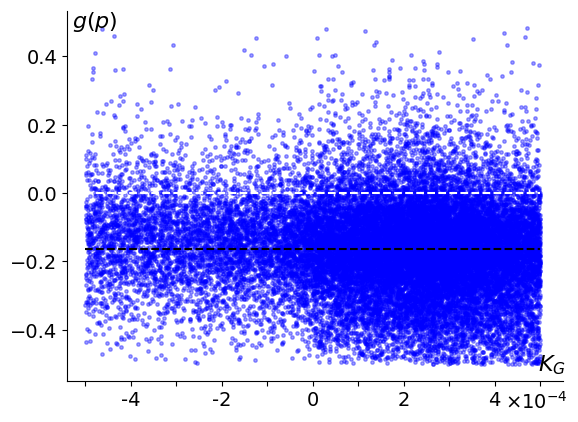

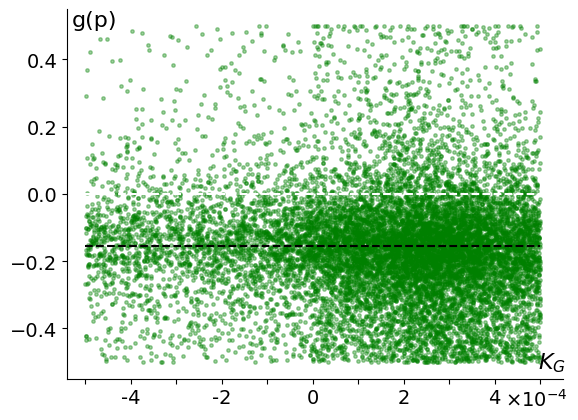

In [13]:
thrsh=0.5
fSize=14

idxTestBdry=np.argwhere(np.abs(vTestKG)<=5.0e-4)
vKGTestBdry=vTestKG[idxTestBdry[:,0]]
vFitBdryModel=model(vTestPoints[idxTestBdry[:,0]])
avgBdryFit=np.sum(vFitBdryModel)/vFitBdryModel.shape[0]
print('average value on fitted boundary points = ',avgBdryFit)
idxValidBdry=np.argwhere(np.abs(vValidTestKG)<=5.0e-4)
vKGValidBdry=vValidTestKG[idxValidBdry[:,0]]
vValidBdryModel=model(vValidTestPoints[idxValidBdry[:,0]])
avgBdryValid=np.sum(vValidBdryModel)/vValidBdryModel.shape[0]
print('average value on validation boundary points = ',avgBdryValid)
#vSortFitKG=np.argsort(vFitKG)
#vSortValidKG=np.argsort(vValidKG)
fg=plt.figure();ax=fg.add_subplot()
#ax.plot(vFitKG[vSortFitKG],vFitBdryModel[vSortFitKG]-thrsh,color='k')
ax.scatter(vKGTestBdry,vFitBdryModel-thrsh,color='b',s=6,alpha=0.37,rasterized=True)
ax.plot([-5.0e-4,5.0e-4],[0.5-thrsh,0.5-thrsh],color='w',linestyle='--')
ax.plot([-5.0e-4,5.0e-4],[avgBdryFit-thrsh,avgBdryFit-thrsh],color='k',linestyle='--')
xticks=[x/10.0**4 for x in range(-5,6,1)]
xticksLabels=[str(x) if (x%2==0)  else '' for x in range(-5,6)]
##xticksLabels[0::2]=''  ##[x if (x%2==0) else '' for x in range(-5,6)]
##xticksLabels[-1]+=r'$\times 10^{-4}$'
ax.set_xticks(xticks);ax.set_xticklabels(xticksLabels,fontsize=fSize)
ytl=ax.get_yticklabels();ax.set_yticklabels(ytl,fontsize=fSize)
x1,x2=ax.get_xlim()
x1+=1e-5;x2+=1e-7
ax.set_xlim([x1,x2])
y1,y2=ax.get_ylim()
ax.text(0.9*x2,0.03+y1,r'$K_G$',fontsize=16)
ax.text(x1+0.01*(x2-x1),0.91*y2,r'$g(p)$',fontsize=16)
ax.text(0.77*x2,y1-0.074*(y2-y1),r'$\times 10^{-4}$',fontsize=fSize)
ax.spines[['right', 'top']].set_visible(False)
fg.savefig(wdir+fName+'modelBdryTest2.'+frmt,format=frmt,dpi=300,bbox_inches='tight',facecolor='w')
fg2=plt.figure();ax2=fg2.add_subplot()
#ax2.plot(vValidKG[vSortValidKG],vValidBdryModel[vSortValidKG]-thrsh,color='r')
ax2.scatter(vKGValidBdry,vValidBdryModel-thrsh,color='g',s=6,alpha=0.37,rasterized=True)
ax2.plot([-5.0e-4,5.0e-4],[0.5-thrsh,0.5-thrsh],color='w',linestyle='--')
ax2.plot([-5.0e-4,5.0e-4],[avgBdryValid-thrsh,avgBdryValid-thrsh],color='k',linestyle='--')
ax2.set_xticks(xticks);ax2.set_xticklabels(xticksLabels,fontsize=fSize)
ytl=ax2.get_yticklabels();ax2.set_yticklabels(ytl,fontsize=fSize)
x1,x2=ax2.get_xlim()
x1+=1e-5;x2+=1e-7
ax2.set_xlim([x1,x2])
y1,y2=ax2.get_ylim()
ax2.text(0.9*x2,0.03+y1,r'$K_G$',fontsize=16)
ax2.text(x1+0.01*(x2-x1),0.91*y2,r'g(p)',fontsize=16)
ax2.text(0.77*x2,y1-0.074*(y2-y1),r'$\times 10^{-4}$',fontsize=fSize)
ax2.spines[['right', 'top']].set_visible(False)
fg2.savefig(wdir+fName+'modelBdryValid2.'+frmt,format=frmt,dpi=300,bbox_inches='tight',facecolor='w')
plt.show()

In [14]:
vw=model.get_weights()
k=0
for w in vw:
    print(k,'  ', w.shape);k+=1
print(vw[3].shape)
print(vw[3][45:55])
print(vw[3][145:155])
imax=np.argmax(np.abs(vw[3]))
print('index of max = ',imax)
print('max value = ',vw[3][imax])
print(vw[2][np.argwhere(vw[2][:,imax]>=0.001),imax])

0    (8, 200)
1    (200,)
2    (200, 200)
3    (200,)
4    (200, 1)
5    (1,)
(200,)
[-0.14399418 -0.14387283 -0.49167636 -0.14371994 -0.14387661 -0.14387995
 -0.14386313 -0.14389195 -0.14387845 -0.14387707]
[-0.14119688 -0.14388011 -0.14388013 -1.6951054  -0.1438914  -0.86540496
 -0.14379682 -0.14387283 -0.14387973 -0.14386405]
index of max =  116
max value =  3.5235853
[[0.14575072]
 [0.95008   ]
 [0.34630692]
 [0.17725073]
 [0.08303659]
 [0.09003949]
 [0.77733284]
 [0.4311184 ]
 [0.6823083 ]
 [1.130277  ]
 [0.3778853 ]
 [1.7140261 ]
 [1.2285904 ]
 [0.14377491]
 [0.6310919 ]
 [0.1831849 ]
 [0.3283048 ]]


(4437, 2)
[-6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7]
(4656, 2)
(4656,)
Layer 2: number of weights >0.0001 = 4656


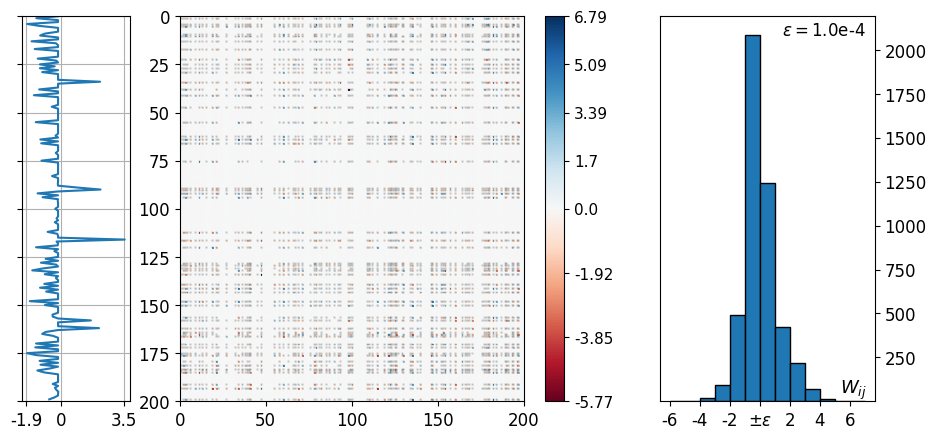

In [ ]:
#frmt='png'
frmt='pdf'
if(1):
    ##eps=1.0e-4
    kk=2
    w=vw[kk]
    ##fg1=plt.figure(figsize=(10,5))
    #fg1, (ax11, ax1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 4]},figsize=(9,5))
    fg1, (ax11, ax1,ax3) = plt.subplots(1, 3, gridspec_kw={'width_ratios': [1, 4,2]},figsize=(11,5))
    ax11.invert_yaxis()
    ax11.set_ylim(vw[kk+1].shape[0],0)
    ax11.plot(vw[kk+1][-1::-1],range(0,vw[kk+1].shape[0])[-1::-1])
    #ax11.plot(vw[kk+1],range(vw[kk+1].shape[0]))
    #ax11.invert_yaxis()
    ax11.grid()
    ax11.set_yticklabels([])
    #ax11.spines[['left']].set_visible(False)
    #ax11.set_xticklabels([str(x) for x in ax11.get_xticks()],fontsize=12)
    ax11Xticks=[round(np.min(vw[kk+1]),1),0,round(np.max(vw[kk+1]),1)]
    ax11.set_xticks(ax11Xticks)
    ax11.set_xticklabels([str(x) for x in ax11Xticks],fontsize=12)
    maxW,minW=np.max(w),np.min(w)
    #cmap1=ax1.imshow(w.T, cmap=plt.cm.RdBu,aspect='equal',vmin=0,vmax=maxW)
    #cmap1=ax1.imshow(w.T, cmap=plt.cm.RdBu,aspect='auto',vmin=0,vmax=maxW)
    #cmap1=ax1.imshow(w.T, cmap=plt.cm.Blues,aspect='auto',vmin=0,vmax=maxW)
    #cmap1=ax1.imshow(w.T,interpolation='none', cmap=plt.cm.Greys,aspect='auto',vmin=0,vmax=maxW)
    #cmap1=ax1.imshow(w.T,interpolation='none', cmap=plt.cm.binary,aspect='auto',vmin=0,vmax=maxW)
    norm = TwoSlopeNorm(vmin=minW, vcenter=0, vmax=maxW)
    #cmap1=ax1.imshow(w.T,interpolation='none', cmap=plt.cm.seismic_r,aspect='auto',vmin=minW,vmax=maxW)
    #cmap1=ax1.imshow(w.T,interpolation='nearest', cmap=plt.cm.RdBu,aspect='auto',norm=norm)
    #cmap1=ax1.pcolormesh(w.T, cmap=plt.cm.RdBu,norm=norm,alpha=1,shading='flat',antialiased=True)
    idxw=np.argwhere(np.abs(w)>=1.0e-2);print(idxw.shape)
    ##ax1.scatter(idxw[:,0],idxw[:,1],marker='o',s=10,c=plt.cm.RdBu(norm(w[idxw[:,1],idxw[:,0]])),alpha=1 ,cmap=plt.cm.RdBu,norm=norm)
    cmap1=ax1.pcolormesh(w.T, cmap=plt.cm.RdBu,norm=norm,alpha=1,shading='flat',antialiased=True,rasterized=True)
    ax1.scatter(idxw[:,0],idxw[:,1],marker='o',s=1,color='black',alpha=0.1,rasterized=True)
    cbartick=np.concatenate((np.linspace(minW,0.0,4),np.linspace(0.0,maxW,5)[1:]))
    cbar=fg1.colorbar(cmap1,ticks=cbartick,ax=ax1)
    cbar.ax.set_yticklabels([str(round(x,2)) for x in cbartick],fontsize=11)
    ax1.set_xlim(0,w.shape[1]);ax1.set_ylim(w.shape[0],0)
    vtickX=np.linspace(0,w.shape[1],5);vtickY=np.linspace(0,w.shape[0],9)
    xtLab=[str(int(x)) for x in vtickX];ytLab=[str(int(x)) for x in vtickY]
    ax1.set_xticks(vtickX);ax1.set_yticks(vtickY[-1::-1])
    ax1.set_xticklabels(xtLab,fontsize=12);ax1.set_yticklabels(ytLab[-1::-1],fontsize=12)
    eps=1.0e-4
    vBins=list(range(int(minW)-1,int(maxW)+2));print(vBins)
    ax3.yaxis.tick_right()
    idxw=np.argwhere(np.abs(w)>=eps);print(idxw.shape)
    zw=w[idxw[:,0],idxw[:,1]];print(zw.shape)
    #ax3.hist(w.reshape(w.shape[0]*w.shape[1]),bins=vBins)
    ax3.hist(zw,bins=vBins, edgecolor='black')
    #xtk=ax3.get_xticks();
    xtk=vBins[0::2]
    ax3.set_xticks(xtk)
    #ax3.set_xticklabels([r'$\epsilon$']+[str(x) for x in xtk[2:]],fontsize=12)
    ax3.set_xticklabels([str(x) if (abs(x)>0) else r'$\pm\epsilon$' for x in xtk],fontsize=12)
    ytk=ax3.get_yticks();ax3.set_yticks(ytk[1:-1])
    ax3.set_yticklabels([str(int(x)) for x in ytk[1:-1]],fontsize=12)
    x1,x2=ax3.get_xlim();y1,y2=ax3.get_ylim()
    ax3.text(x1+0.57*(x2-x1),0.95*y2,r'$\epsilon = $1.0e-4',fontsize=12)
    ax3.text(0.7*x2,0.02*y2,r'$W_{ij}$',fontsize=13)
    fg1.savefig(wdir+fName+f'NN_Layer_{kk}_seismic.'+frmt,format=frmt,dpi=300,bbox_inches='tight',facecolor='w')
    print('Layer {}: number of weights >{} = {}'.format(kk,eps,np.sum(np.abs(w)>eps)))

(261574, 1)
(130942, 1)


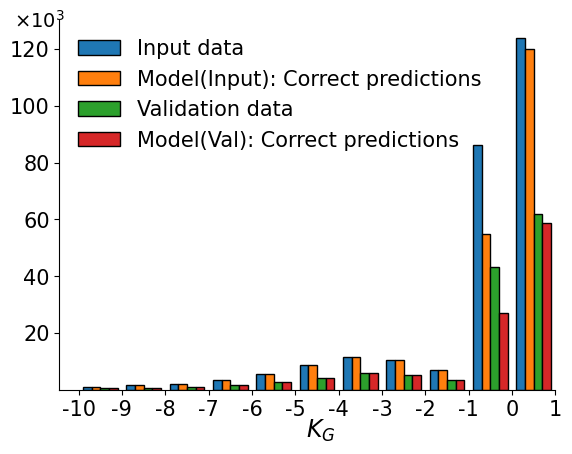

In [ ]:
#frmt='png'
frmt='pdf'
#tminKG=np.min(vValidTestKG);print(f'minKG = {tminKG}')
#tmaxKG=np.max(vValidTestKG);print(f'maxKG = {tmaxKG}')

minKG=-10.0; nx=10; dx=-minKG/nx

idx=np.argwhere(vTestKG>=minKG);print(idx.shape)
##print('number of KGs < -10 = ',vTestKG.shape[0]-idx.shape[0])
vKG=vTestKG[idx[:,0]]

vPredKG=0.5-model(vTestPoints[idx[:,0]]).numpy()
vsgn=np.sign(vPredKG)[:,0].astype(int)-np.sign(vKG).astype(int)
idxTrue=np.argwhere(vsgn==0)
#

idxValid=np.argwhere(vValidTestKG>=minKG);print(idxValid.shape)
##print('number of KGs < -10 = ',vValidTestKG.shape[0]-idx.shape[0])
vKGvalid=vValidTestKG[idxValid[:,0]]

vPredKGvalid=0.5-model(vValidTestPoints[idxValid[:,0]]).numpy()
vsgn=np.sign(vPredKGvalid)[:,0].astype(int)-np.sign(vKGvalid).astype(int)
idxTrueValid=np.argwhere(vsgn==0)
#

fSize=15
if(1):
    #
    vB=[minKG+k*dx for k in range(0,nx+1)]+[0,1]
    fg=plt.figure()
    ax=fg.add_subplot()
    ax.hist([vKG,vKG[idxTrue[:,0]],vKGvalid,vKGvalid[idxTrueValid[:,0]]],vB,edgecolor='black',alpha=1,
            label=['Input data','Model(Input): Correct predictions','Validation data','Model(Val): Correct predictions'])
    #ax.hist(vKG,vB)
    #ax.hist(vKG[idxTrue[:,0]],vB)
    xtk=[-k for k in range(-int(minKG)+1)]+[1]
    xtkL=[str(x) for x in xtk]
    ax.set_xticks(xtk);ax.set_xticklabels(xtkL)
    ax.tick_params(axis='x', labelsize=fSize)
    ax.tick_params(axis='y', labelsize=fSize)
    y1,y2=ax.get_ylim()
    #ax.text(1.2,800,r'$K_G$',fontsize=17)
    ax.text(-4.75,-0.13*y2,r'$K_G$',fontsize=17)
    ytk=ax.get_yticks()
    ytkLab=[str(int(x/1000)) for x in ytk]
    ax.set_yticks(ytk[1:-1])
    ax.set_yticklabels(ytkLab[1:-1])
    ax.text(-11.5,0.98*y2,r'$\times 10^3$',fontsize=14)
    x1,x2=ax.get_xlim();ax.set_xlim([x1,1])
    ax.spines[['right','top']].set_visible(False)
    ax.legend(loc='upper left',fontsize=15,framealpha=0.0)
    fg.savefig(wdir+fName+'KG_HistogramBoth.'+frmt,format=frmt,bbox_inches='tight',dpi=300,facecolor='w')

In [ ]:
!jupyter nbconvert --to html  {wdir+'nb24_aValidCVXdeg4_12_C_9D4.ipynb'}

[NbConvertApp] Converting notebook /content/drive/MyDrive/ysNN/partB/nb24_aValidCVXdeg4_12_C_9D4.ipynb to html
[NbConvertApp] Writing 1355810 bytes to /content/drive/MyDrive/ysNN/partB/nb24_aValidCVXdeg4_12_C_9D4.html
